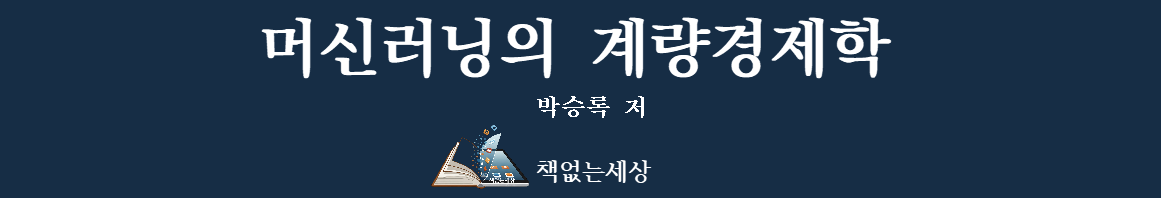

# Part 3. 전통적 계량경제학

## Chapter 7. 최우법(Maximum Likelihood Estimation Method)

### 가. 다중회귀분석 (Multiple Linear Regression)

In [3]:
# 작업공간(working directory)지정  
import os  
os.chdir("E:\JupyterWDirectory\MyStock")
os.getcwd()

'E:\\JupyterWDirectory\\MyStock'

In [2]:
exec(open('E:/JupyterWDirectory/MyStock/Functions/Traditional_Econometrics_Lib.py').read())

In [ ]:
"""
# #####################################################################
# 위의 함수는 아래 다양한 라이브러리와 함수를 한 문장으로 불러오는 방법
# #####################################################################

# 분석에 사용될 라이브러리(Libraries for the Analysis) 불러오기
# Libraries for the Analysis of Traditional Econometrics.py
# 불러오는 방법:  "exec(open('Functions/Traditional_Econometrics_Lib.py').read())"
# #####################################################################

# 만약 특정 라이브러리가 설치되지 않았다는 에러 메시지가 나타날 때는 
# 해당 라이브러리를 설치하여야 함
# 아래 라이브러리를 하나 하나 실행하면서 어떤 라이브러리가 설치되지 않았는지 확인하여도 됨
# #####################################################################
import os
import numpy as np                                       # Numerical calculations
import pandas as pd                                      # Data handling
import math as someAlias
import matplotlib.dates as mdates                        # Turn dates into numbers
import matplotlib.pyplot as plt                          # Lower-level graphics
import patsy as pt
import seaborn as sns
import stargazer.stargazer as sg
import statsmodels.api as sm
import statsmodels.formula.api as smf                    # Econometrics
import statsmodels.stats.api as sms
import statsmodels.stats.diagnostic as dg
import statsmodels.stats.outliers_influence as smo
import linearmodels as lm                                # Panel model, Simultaneous Eq. Model
import scipy.stats as stats                              # Statistics
import random

from scipy.optimize import Bounds
from scipy.optimize import curve_fit                    # Nonlinear regression
from scipy.optimize import minimize
from scipy.stats import norm
from statsmodels.graphics import tsaplots               # Time series
from statsmodels.iolib.summary2 import summary_col
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.api import VAR
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller          # ADF test
from statsmodels.tsa.stattools import coint             # Cointegration
from statsmodels.tsa.vector_ar.vecm import VECM
from arch import arch_model

import wooldridge as woo
from imfpy.retrievals import dots
import wbdata
import yfinance as yf

import warnings
warnings.filterwarnings("ignore")
"""

In [6]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import statsmodels.api as sm
import wooldridge as woo

# 데이터 불러오기
df = woo.dataWoo('gpa1')

# 변수준비
y = df['colGPA']
X = df[['hsGPA', 'ACT', 'skipped']]
X = sm.add_constant(X)  # 상수항 추가

# 정규분포 가정 하에 로그 우도함수 정의
def neg_log_likelihood(params, X, y):
    beta = params[:-1]  # 회귀 계수
    sigma = np.exp(params[-1])  # 오차항 표준편차 (항상 양수가 되도록 exp 사용)
    
    # 예측값 계산
    y_pred = X.dot(beta)
    
    # 로그 우도 계산 (정규분포 가정)
    ll = -0.5 * len(y) * np.log(2 * np.pi) - len(y) * np.log(sigma) - \
         0.5 * np.sum(((y - y_pred) / sigma) ** 2)
    
    return -ll  # 최적화를 위해 음수 로그 우도 반환

# OLS로 초기 파라미터 추정
ols_model = sm.OLS(y, X).fit()
initial_beta = ols_model.params
initial_sigma = np.log(np.std(ols_model.resid)) 

# 파라미터 초기값 정의 
initial_params = np.concatenate([initial_beta, [initial_sigma]])

# 최적화 
result = minimize(neg_log_likelihood, 
                 initial_params, 
                 args=(X, y),
                 method='BFGS',  
                 options={'maxiter': 10000, 'disp': True})

# 결과 출력
beta_mle = result.x[:-1]
sigma_mle = np.exp(result.x[-1])  # 다시 원래 스케일로 변환
print("MLE Coefficients:", beta_mle)
print("MLE Sigma:", sigma_mle)

# OLS 결과와 비교
print("\nOLS Coefficients:")
print(ols_model.params)
print("OLS Sigma:", np.std(ols_model.resid))

         Current function value: 41.500699
         Iterations: 0
         Function evaluations: 252
         Gradient evaluations: 40
MLE Coefficients: [ 1.38955383  0.41181617  0.01472023 -0.08311314]
MLE Sigma: 0.3247799725001268

OLS Coefficients:
const      1.389554
hsGPA      0.411816
ACT        0.014720
skipped   -0.083113
dtype: float64
OLS Sigma: 0.3247799725001268


### 나. 로지스틱 회귀

In [7]:
import numpy as np
from scipy.optimize import minimize
import statsmodels.api as sm

# 데이터 생성
np.random.seed(42)
n = 1000
X = np.random.normal(0, 1, (n, 2))
X = np.column_stack([np.ones(n), X])  # 상수항 추가
beta_true = np.array([1, 2, -1.5])
p = 1 / (1 + np.exp(-X @ beta_true))  # 로지스틱 함수
y = np.random.binomial(1, p)

# 로짓 모형의 로그 우도함수 정의
def neg_log_likelihood_logit(beta, y, X):
    xbeta = X @ beta
    # 수치적 안정성을 위한 처리
    xbeta = np.clip(xbeta, -30, 30)
    
    # 로지스틱 함수
    p = 1 / (1 + np.exp(-xbeta))
    
    # 로그 우도함수
    ll = np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))
    
    return -ll  # 최소화 문제로 변환

# 최우추정
initial_beta = np.zeros(X.shape[1])
result = minimize(neg_log_likelihood_logit, initial_beta, args=(y, X),
                 method='BFGS')
beta_mle = result.x

# statsmodels 결과와 비교
logit_model = sm.Logit(y, X).fit(disp=0)

print("최우추정 결과:")
print(f"Beta: {beta_mle}")
print("\nStatsmodels 결과:")
print(f"Beta: {logit_model.params}")

최우추정 결과:
Beta: [ 1.09951723  2.20369233 -1.5507216 ]

Statsmodels 결과:
Beta: [ 1.09951719  2.20369221 -1.55072153]


### 바. 포아송 회귀

In [9]:
import numpy as np
from scipy.optimize import minimize
import statsmodels.api as sm

# 데이터 생성
np.random.seed(42)
n = 500
X = np.random.normal(0, 1, (n, 2))
X = np.column_stack([np.ones(n), X])  # 상수항 추가
beta_true = np.array([1, 0.5, -0.3])
lambda_i = np.exp(X @ beta_true)
y = np.random.poisson(lambda_i)

# 포아송 회귀의 로그 우도함수 정의
def neg_log_likelihood_poisson(beta, y, X):
    xbeta = X @ beta
    lambda_i = np.exp(xbeta)
    
    # 로그 우도함수 (log(y!)은 상수이므로 최적화에서 제외)
    ll = np.sum(y * xbeta - lambda_i)
    
    return -ll  # 최소화 문제로 변환

# 최우추정
initial_beta = np.zeros(X.shape[1])
result = minimize(neg_log_likelihood_poisson, initial_beta, args=(y, X),
                 method='BFGS')
beta_mle = result.x

# statsmodels 결과와 비교
poisson_model = sm.GLM(y, X, family=sm.families.Poisson()).fit()

print("최우추정 결과:")
print(f"Beta: {beta_mle}")
print("\nStatsmodels 결과:")
print(f"Beta: {poisson_model.params}")

# 과산포 검정
y_pred = np.exp(X @ beta_mle)
dispersion = np.sum((y - y_pred)**2 / y_pred) / (n - X.shape[1])

print(f"\n추정된 과산포 계수: {dispersion}")
if dispersion > 1.5:
    print("과산포가 관찰됨: 음이항 회귀 고려 필요")
else:
    print("과산포 문제 없음: 포아송 회귀 적합")

# 실제 응용 예: 음이항 회귀 구현
if dispersion > 1.5:
    nb_model = sm.NegativeBinomial(y, X).fit()
    print("\n음이항 회귀 결과:")
    print(f"Beta: {nb_model.params}")

최우추정 결과:
Beta: [ 1.01547146  0.45397873 -0.28748481]

Statsmodels 결과:
Beta: [ 1.01547147  0.45397874 -0.2874848 ]

추정된 과산포 계수: 0.9802401881720707
과산포 문제 없음: 포아송 회귀 적합


## 5. 최우법에서 경사 하강법

156번 반복 후 수렴
진짜 매개변수: [-0.5  1.  -1. ]
MLE 추정치: [-0.81224534  0.9889131  -1.4304866 ]


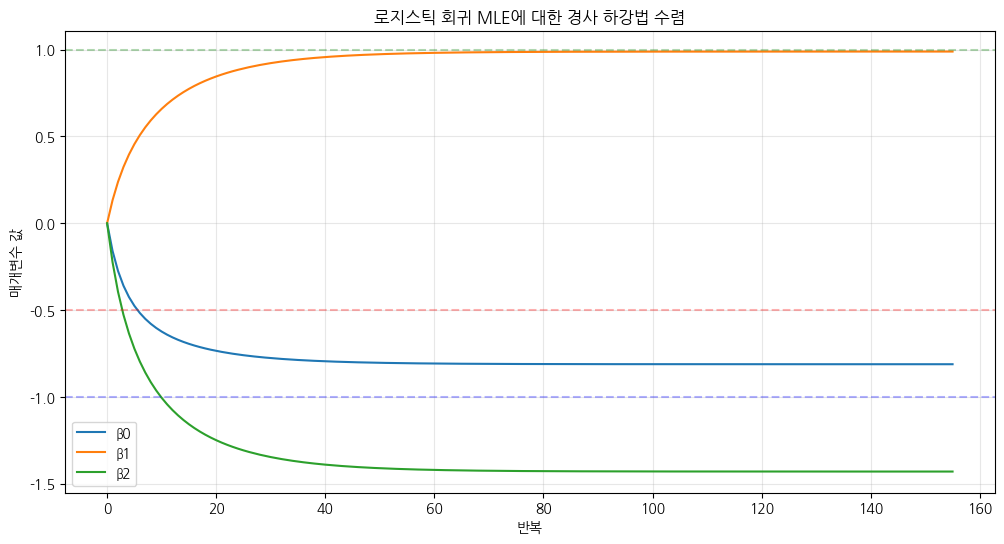

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# 예제: 경사 하강법을 사용한 로지스틱 회귀
def logistic(z):
    return 1 / (1 + np.exp(-z))

# 샘플 데이터 생성
np.random.seed(42)
n = 100
X = np.random.randn(n, 2)
true_beta = np.array([-0.5, 1, -1])
z = X @ true_beta[1:] + true_beta[0]
p = logistic(z)
y = np.random.binomial(1, p)

# 절편 열 추가
X_with_intercept = np.column_stack((np.ones(n), X))

# 로지스틱 회귀에 대한 로그우도의 기울기
def grad_log_likelihood(beta, X, y):
    z = X @ beta
    p = logistic(z)
    return X.T @ (y - p)

# MLE를 위한 경사 하강법
def gradient_descent_mle(X, y, learning_rate=0.01, max_iter=10000, tol=1e-6):
    beta = np.zeros(X.shape[1])
    beta_history = [beta.copy()]
    
    for i in range(max_iter):
        gradient = grad_log_likelihood(beta, X, y)
        beta_new = beta + learning_rate * gradient
        
        # 수렴 확인
        if np.linalg.norm(beta_new - beta) < tol:
            print(f"{i+1}번 반복 후 수렴")
            break
            
        beta = beta_new
        beta_history.append(beta.copy())
    
    return beta, np.array(beta_history)

# 경사 하강법 실행
beta_mle, beta_history = gradient_descent_mle(X_with_intercept, y)
print(f"진짜 매개변수: {true_beta}")
print(f"MLE 추정치: {beta_mle}")

# 수렴 시각화
plt.figure(figsize=(12, 6))
for i in range(3):
    plt.plot(beta_history[:, i], label=f'β{i}')
plt.axhline(y=true_beta[0], color='r', linestyle='--', alpha=0.3)
plt.axhline(y=true_beta[1], color='g', linestyle='--', alpha=0.3)
plt.axhline(y=true_beta[2], color='b', linestyle='--', alpha=0.3)
plt.xlabel('반복')
plt.ylabel('매개변수 값')
plt.title('로지스틱 회귀 MLE에 대한 경사 하강법 수렴')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#### 확률변경생산함수, 확률변경비용함수는 다른 파일 참조